## Subset sampling for GHZ state preparation circuit

**1. Direct Monte Carlo approach**

CPU times: user 18.1 s, sys: 746 ms, total: 18.9 s
Wall time: 17.8 s


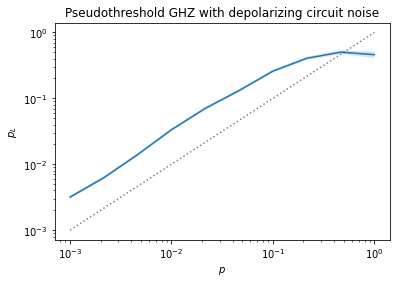

In [59]:
%%time

import pecos as pc
import numpy as np
import matplotlib.pyplot as plt

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})

circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))
depolar_gen = pc.error_gens.DepolarGen(model_level='circuit')

def MC(p, n_samples):
    logical_errs = 0
    for _ in range(n_samples):
        sim = pc.simulators.SparseSim(5)
        msmt, _ = circ_runner.run(sim, ghz, error_gen=depolar_gen, error_params={'p':p})
        if msmt: 
            logical_errs += 1
    return logical_errs

def MC_gen_p_L(p_phy, sample_range):
    p_L= np.empty_like(p_phy)
    for i, p in enumerate(p_phy):
        n_fails = MC(p, sample_range[i])
        p_L[i] = n_fails / sample_range[i]
    p_L_err = np.sqrt(p_L*(1-p_L)/sample_range)
    return p_L, p_L_err

p_phy = np.logspace(-3, 0, 10) # evenly spaced samples in log space
n_samples = 100
sample_range = np.int_(n_samples / p_phy) # take more samples for lower p_phy
p_L, p_L_err = MC_gen_p_L(p_phy, sample_range)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
plt.title('Pseudothreshold GHZ with depolarizing circuit noise')
plt.plot(p_phy, p_L)
plt.fill_between(p_phy, p_L-p_L_err, p_L+p_L_err, alpha=0.2)
plt.plot(p_phy, p_phy, 'k:', alpha=0.5)

**2. Subset sampling approach**

CPU times: user 1.12 s, sys: 706 ms, total: 1.83 s
Wall time: 706 ms


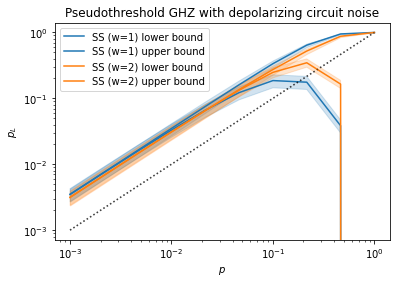

In [3]:
%%time

import itertools
import math
import pecos as pc
import numpy as np
import matplotlib.pyplot as plt

circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})

two_qb_gates = ['CNOT']
one_qb_gates = ['measure Z', 'H']
one_qb_errs = ['X','Y','Z']
two_qb_errs  = list(itertools.product(one_qb_errs + ["I"], repeat=2)) # variation with repetition
two_qb_errs.remove(('I','I')) # remove II as it is not a fault

def subset_sample(ref_circuit, subset_weight, n_samples):
    logical_fails = 0
    for _ in range(n_samples):
        
        # 1. Generate a subset circuit, place random faults at w gates
        subset_circuit = ref_circuit.copy()
        fault_locs = np.random.choice(len(subset_circuit), subset_weight, replace=False)
        for loc in fault_locs:
            for sym, qbs, params in subset_circuit[loc].items():
                if sym in two_qb_gates: 
                    faults = two_qb_errs[np.random.choice(len(two_qb_errs))]
                    for fault, qb in zip(faults, list(*qbs)):
                        if fault != "I": 
                            subset_circuit.insert(loc, ({fault: {qb}}, {}))
                elif sym in one_qb_gates: 
                    fault = np.random.choice(one_qb_errs)
                    subset_circuit.insert(loc, ({fault: qbs}, {}))
                    
        # 2. Simuluate a circuit run with |00..0> and measure in Z
        sim = pc.simulators.SparseSim(5)
        msmt, _ = circ_runner.run(sim, subset_circuit)
        
        # 3.Count logical failures
        if msmt: logical_fails += 1
        
    return logical_fails

n_samples = 20 # number of samples per subset
p_phy = np.logspace(-3, 0, 10) # physical error rates
n_gates = len(ghz) # number of gates in reference circuit

def SS_gen_p_L_w(w_max, p_phy, n_samples):
    # Subset logical failure rates: Weight-0 faults have failure rate 0.
    p_L_w = np.array([0] + [subset_sample(ghz,w,n_samples)/n_samples for w in range(1,w_max+1)])

    # Binomial weight: Tot. probability of sampling weight-w circuits from all possible circuits
    A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
    A = np.array([[A_w(p,w,n_gates) for p in p_phy] for w in range(w_max+1)])

    # Overall bounded logical failure rates
    p_L_low = np.sum(A * p_L_w[:,None], axis=0)
    p_L_up = p_L_low + 1 - np.sum(A, axis=0)

    # Subset and overall standard deviations
    e_SS_w = lambda p, n: np.sqrt( (p * (1-p)) / n )
    e_SS = np.sqrt( np.sum((A[1:] * e_SS_w(p_L_w[1:,None], n_samples))**2, axis=0) )
    return p_L_low, p_L_up, e_SS

cols = ['tab:blue', 'tab:orange']
w_max = 2 # gate fault cutoff
for col, w_m in zip(cols,range(1,w_max+1)):
    p_L_low, p_L_up, e_SS = SS_gen_p_L_w(w_m, p_phy, n_samples)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$p$')
    plt.ylabel(r'$p_L$')
    plt.title('Pseudothreshold GHZ with depolarizing circuit noise')
    plt.plot(p_phy, p_L_low, c=col, label="SS (w=%s) lower bound" % w_m)
    plt.fill_between(p_phy, p_L_low-e_SS, p_L_low+e_SS, alpha=0.2, color=col)
    plt.plot(p_phy, p_L_up, label="SS (w=%s) upper bound" % w_m, c=col)
    plt.fill_between(p_phy, p_L_up-e_SS, p_L_up+e_SS, alpha=0.2, color=col)
    plt.plot(p_phy, p_phy, 'k:', alpha=0.5)
plt.legend()

**3. Comparison plot**

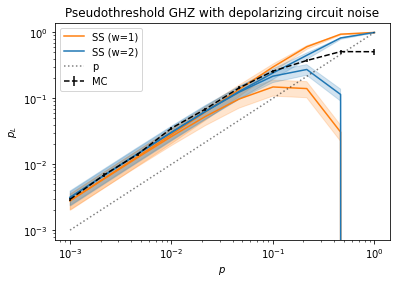

In [53]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
plt.title('Pseudothreshold GHZ with depolarizing circuit noise')

n_samples = 20 # number of samples per subset
p_phy = np.logspace(-3, 0, 10) # physical error rates

for col, w_m in zip(['tab:orange', 'tab:blue'],[1,2]):
    p_L_low, p_L_up, e_SS = SS_gen_p_L_w(w_m,p_phy,n_samples)
    plt.plot(p_phy, p_L_low, c=col, label="SS (w=%s)"%w_m)
    plt.fill_between(p_phy, p_L_low-e_SS, p_L_low+e_SS, color=col, alpha=0.2)
    plt.plot(p_phy, p_L_up, c=col)
    plt.fill_between(p_phy, p_L_up-e_SS, p_L_up+e_SS, color=col, alpha=0.2)

plt.errorbar(p_phy, p_L, fmt='--', c="black", yerr=p_L_err, label="MC")
plt.plot(p_phy, p_phy, 'k:', alpha=0.5, label="p")
plt.legend()

**3.1. Behavior for increasing w_max $\rightarrow$ n_gates**

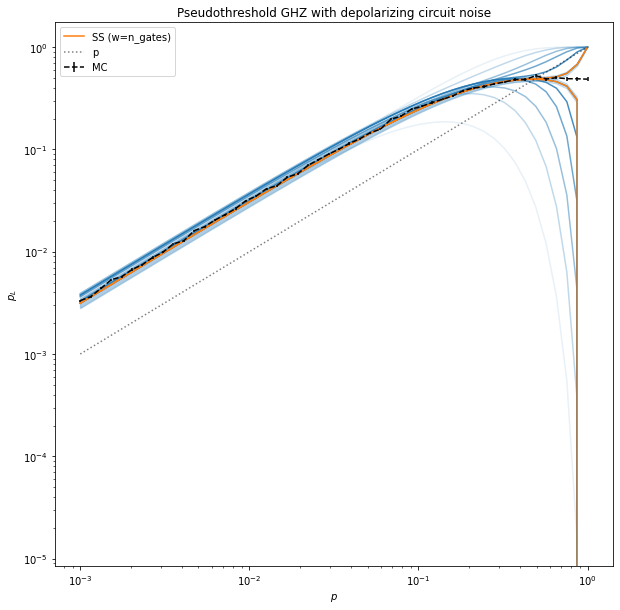

In [60]:
plt.figure(figsize=(10,10))

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
plt.title('Pseudothreshold GHZ with depolarizing circuit noise')

n_samples = 100 # number of samples per subset
p_phy = np.logspace(-3, 0, 50) # physical error rates
alphas = np.linspace(0.1, 1, n_gates-1) # increase opacity

for alpha, w_m in zip(alphas, range(1,n_gates)):
    p_L_low, p_L_up, e_SS = SS_gen_p_L_w(w_m,p_phy,n_samples)
    plt.plot(p_phy, p_L_low, c=col, alpha=alpha)
    plt.plot(p_phy, p_L_up, c=col, alpha=alpha)

plt.plot(p_phy, p_L_low, c='tab:orange', label="SS (w=n_gates)")
plt.fill_between(p_phy, p_L_low-e_SS, p_L_low+e_SS, color=col, alpha=0.2)
plt.plot(p_phy, p_L_up, c='tab:orange')
plt.fill_between(p_phy, p_L_up-e_SS, p_L_up+e_SS, color=col, alpha=0.2)

n_samples = 500
sample_range = np.int_(n_samples / p_phy) # take more samples for lower p_phy
p_L, p_L_err = MC_gen_p_L(p_phy, sample_range)
plt.errorbar(p_phy, p_L, fmt='--', c="black", yerr=p_L_err, label="MC")
plt.plot(p_phy, p_phy, 'k:', alpha=0.5, label="p")
plt.legend()

**3.2. SS Convergence at low p**

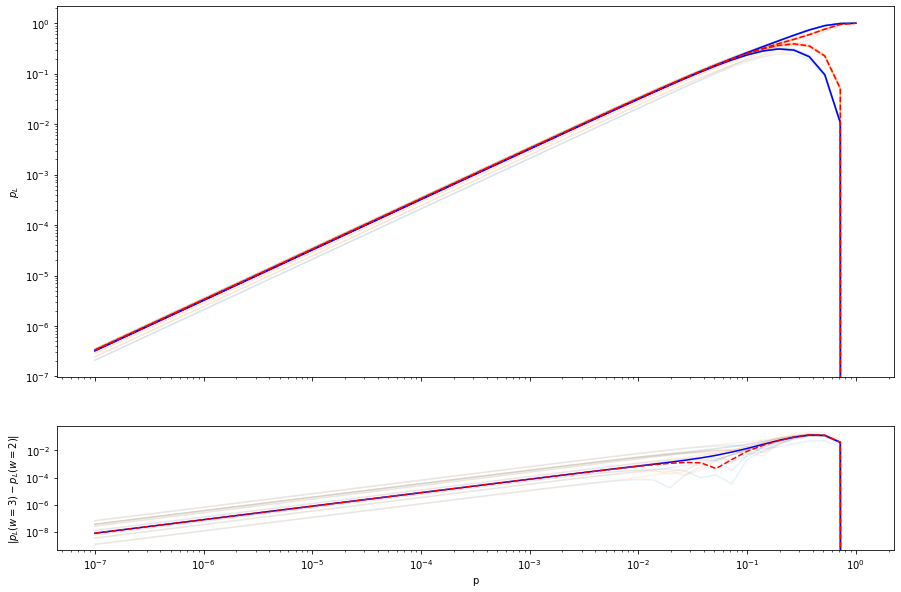

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,10), gridspec_kw={'height_ratios': [3,1]})

samples = np.arange(20, 1000, 100)
p_phy = np.logspace(-7, 0, 50) # physical error rates
alpha=0.1
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylabel(r'$p_L$')
ax[1].set_xlabel('p')
ax[1].set_ylabel(r'$|p_L(w=3)-p_L(w=2)|$')


for n_samples in samples:
    p_L_low1, p_L_up1, _ = SS_gen_p_L_w(2,p_phy,n_samples)
    ax[0].plot(p_phy, p_L_low1, c='tab:blue', alpha=alpha)
    ax[0].plot(p_phy, p_L_up1, c='tab:blue', alpha=alpha)
    p_L_low2, p_L_up2, _ = SS_gen_p_L_w(3,p_phy,n_samples)
    ax[0].plot(p_phy, p_L_low2, c='tab:orange', alpha=alpha)
    ax[0].plot(p_phy, p_L_up2, c='tab:orange', alpha=alpha)
    
    diff_low = abs(p_L_low1-p_L_low2)
    diff_up = abs(p_L_up1-p_L_up2)
    ax[1].plot(p_phy, diff_low, c='tab:blue', alpha=alpha)
    ax[1].plot(p_phy, diff_up, c='tab:orange', alpha=alpha)

ax[0].plot(p_phy, p_L_low1, c='blue')
ax[0].plot(p_phy, p_L_up1, c='blue')
ax[0].plot(p_phy, p_L_low2, '--', c='red')
ax[0].plot(p_phy, p_L_up2, '--', c='red')

ax[1].plot(p_phy, diff_low, c='blue')
ax[1].plot(p_phy, diff_up, '--', c='red')

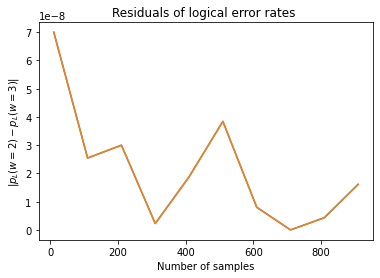

In [192]:
p_phy = [1e-7] # fix physical error rate
samples = np.arange(10, 1000, 100) # increasing no. of samples

diffs_low, diffs_up = [], [] # track difference 
for n_samples in samples:
    p_L_low1, p_L_up1, _ = SS_gen_p_L_w(2,p_phy,n_samples)
    p_L_low2, p_L_up2, _ = SS_gen_p_L_w(3,p_phy,n_samples)
    diffs_low.append(abs(p_L_low1 - p_L_low2))
    diffs_up.append(abs(p_L_up1 - p_L_up2))

plt.title("Residuals of logical error rates ")
plt.xlabel('Number of samples')
plt.ylabel(r'$|p_L(w=2)-p_L(w=3)|$')
plt.plot(samples, diffs_low)
plt.plot(samples, diffs_up)

## This looks weird, i would expect the difference to converge to 0 with increasing sample size..
## Any idea what's going on here?